In [84]:
import random
import pickle
import math
import nltk

import pandas as pd
import numpy as np
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

Import in all the data

In [86]:
converter = lambda x: list(map(lambda y: y.strip("'"), x.strip("[]").split(", ")))

df = pd.read_csv('..\data\data_lem.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)
#lowercase
a = [col.lower() for col in df.columns]
df.columns = a
#preview
df.head(10)

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
C:\Users\Mohammed\AppData\Local\Temp/ipykernel_21780/3447199195.py:3: DeprecationWarning: invalid escape sequence \d
  df = pd.read_csv('..\data\data_lem.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)


,email,lemmatized,spam
0,"[christmas, tree, farm, pictures]","[christmas, tree, farm, picture]",False
1,"[calpine, daily, gas, nomination, calpine, dai...","[calpine, daily, gas, nomination, calpine, dai...",False
2,"[mcmullen, gas, jackie, since, inlet, river, p...","[mcmullen, gas, jackie, since, inlet, river, p...",False
3,"[meter, 1517, jan, 1999, george, need, followi...","[meter, 1517, jan, 1999, george, need, follow,...",False
4,"[king, ranch, two, fields, gas, difficulty, un...","[king, ranch, two, field, gas, difficulty, uni...",False
5,"[entex, transistion, purpose, email, recap, ki...","[entex, transistion, purpose, email, recap, ki...",False
6,"[unify, close, schedule, following, close, sch...","[unify, close, schedule, following, close, sch...",False
7,"[meter, 1431, nov, 1999, aimee, sitara, deal, ...","[meter, 1431, nov, 1999, aimee, sitara, deal, ...",False
8,"[texas, log, name, home, pager, george, grant,...","[texas, log, name, home, pager, george, grant,...",False
9,"[meter, 1441, falfurrias, daren, need, help, r...","[meter, 1441, falfurrias, daren, need, help, r...",False


In [87]:
'{:,}'.format(len(df))

'24,932'

Start creating CV sets. We are going to perform 10-fold CV.

We start by shuffling the data

In [88]:
#set seed
random.seed(a=42)
#rearrange index
ind = list(range(0,len(df)))
random.shuffle(ind)
ind[:10] 

[3656, 22400, 22323, 3126, 13821, 12909, 24764, 13486, 21779, 1132]

In [89]:
#create a rearranged df. we use only use lemmatized emails from now on
temp_df = df.iloc[ind][['lemmatized','spam']]
temp_df.head()

,lemmatized,spam
3656,"[logistics, sycamore, meeting, chelmsford, nex...",False
22400,"[surprise, girlfriend, night, make, feel, well...",True
22323,"[1842, radio, 1924, martha, stewartdo, city, n...",True
3126,"[welcome, online, affair, network, massive, ci...",True
13821,"[longlasting, erection, new, clalls, softtabs,...",True


We continue with an 80:20 split for train:test. Our training set is then split into 10-folds.

In [90]:
#our dataframe does not perfectly divide
len(temp_df)/5

4986.4

In [91]:
#we use the floor function for better a better divisor of data
five_floor = math.floor(len(temp_df)/5)
five_floor

4986

In [93]:
#we take everything after the '80th percentile' as test set
#this will be 2 entries longer than our other sets
test_df = temp_df.iloc[4*five_floor:] 
len(test_df), test_df.head()

(4988,
                                               lemmatized   spam
 3910   [pres, delainy, sorry, vince, please, use, fil...  False
 16837  [msnbc, rate, hit, year, low, 28940, hundred, ...   True
 5694   [internet, news, feed, executive, dfvht, final...   True
 21530  [parcelas, pucon, puede, ver, aviso, haga, cli...   True
 2440   [stop, pay, pay, per, view, channel, fri, apr,...   True)

In [94]:
#we take everything up to '80th percentile' as train set
train_df = temp_df.iloc[:4*five_floor]
len(train_df), train_df.tail() #checking that there's no entry overlap with test_df

(19944,
                                               lemmatized   spam
 18238  [entrust, visual, identity, think, breathe, ne...   True
 9145   [uluslararasi, telefon, grmelernde, byk, tasar...   True
 14041  [iagra, fashion, find, new, clalls, softtabs, ...   True
 1331   [south, hampton, refining, add, deal, 541123, ...  False
 23722  [surf, charset, big, marketing, exhibition, of...   True)

In [95]:
ten_floor = math.floor(len(train_df)/10)
ten_floor

1994

Now we shuffle the train_df as we shuffled the original df before (this is mainly to create a new set of indices)

In [97]:
#set seed
random.seed(a=42)
#rearrange index
ind = list(range(0,len(train_df)))
random.shuffle(ind)
ind[:10] 

[19175, 1531, 1546, 15922, 16126, 677, 6820, 13224, 18682, 13659]

We not create our 10 splits of the training dataset

In [99]:
train_df = train_df.iloc[ind]
train_df.head()

,lemmatized,spam
14595,"[good, idea, original, replica, rolex, handwat...",True
16896,"[vehicle, make, noise, aak, protect, financial...",True
5964,"[claim, free, home, depot, gift, card, 1000, v...",True
13805,"[brother, cop, pain, finish, pain, husband, pa...",True
6016,"[graphic, software, available, cheap, oem, ver...",True


In [100]:
for i in range(0,10):
    start = ten_floor*i
    end = ten_floor*(i+1)

    #we create 9 equal datafrmes
    if i < 9:
        a = ind[start:end]
    else:
        a = ind[start:] #10th dataframes is larger by 4 entries
        
    locals()['df_{}'.format(i)] = train_df.iloc[a][['lemmatized','spam']]

In [101]:
df_0

,lemmatized,spam
11814,"[miningnews, net, newsletter, tuesday, january...",True
20956,"[software, update, save, microsoft, window, pr...",True
5828,"[save, money, buy, get, thing, try, cialls, ye...",True
4906,"[real, option, conference, vince, bring, atten...",False
16712,"[credit, processing, easy, 189, aredit, cpprov...",True
...,...,...
15664,"[global, intelligence, status, attach, summary...",False
7327,"[draft, response, ferc, staff, attach, draft, ...",False
4010,"[mid, year, 2000, performance, feedback, note,...",False
10911,"[start, date, hourahead, hour, start, date, ho...",False


In [102]:
df_9

,lemmatized,spam
73,"[rollout, schedule, unify, real, time, deal, p...",False
8565,"[overdue, margin, louise, two, counterparties,...",False
3585,"[congratulation, vince, congratulation, wish, ...",False
23697,"[young, pro, office, adobe, photoshop, acrobat...",True
6939,"[california, update, executive, summary, under...",False
...,...,...
21506,"[stock, business, rev, water, ibe, financial, ...",True
17651,"[get, order, anything, sell, opt, mail, advert...",True
9278,"[new, mitrosoft, sofftwarre, hugely, llemd, he...",True
18058,"[source, best, viagra, deal, net, always, date...",True


Now that we have 10 dataframes, we will create 10 different training/validation splits.

We will have 
 - split 0: df_0 = validation, df_1:df_9 = train
 - split 1: df_1 = validation, df_0, df_2:df_9 = train
 - ... and so on.
 


In [103]:
for i in range(0,10):
    ks = []
    #we create val_df_i out of df_i
    locals()['val_df_{}'.format(i)] = locals()['df_{}'.format(i)]
    
    #we create a list of all df_k where k!=i
    for k in range(0,10):
        if k!=i:
            df_k = locals()['df_{}'.format(k)] 
            ks.append(df_k)
            
    #concatenate df_k's into train_df_i
    locals()['train_df_{}'.format(i)] = pd.concat(ks)

In [104]:
#preview
val_df_0, train_df_0

(                                              lemmatized   spam
 11814  [miningnews, net, newsletter, tuesday, january...   True
 20956  [software, update, save, microsoft, window, pr...   True
 5828   [save, money, buy, get, thing, try, cialls, ye...   True
 4906   [real, option, conference, vince, bring, atten...  False
 16712  [credit, processing, easy, 189, aredit, cpprov...   True
 ...                                                  ...    ...
 15664  [global, intelligence, status, attach, summary...  False
 7327   [draft, response, ferc, staff, attach, draft, ...  False
 4010   [mid, year, 2000, performance, feedback, note,...  False
 10911  [start, date, hourahead, hour, start, date, ho...  False
 24475  [software, understand, oem, software, lead, te...   True
 
 [1994 rows x 2 columns],
                                               lemmatized   spam
 13799  [italian, craft, rolex, 275, free, shipping, h...   True
 1126   [tenaska, gas, management, agreement, daren, g...  Fal

Now we create 10 dictioanries for each of our training sets.

In [105]:
for i in range(0,10):
    #create dictionary_i out of train_df_i
    locals()['dictionary_{}'.format(i)] = gensim.corpora.Dictionary(locals()['train_df_{}'.format(i)].lemmatized)

In [106]:
#we have a preview of one of our dictionaries
count = 0

for index,word in dictionary_1.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break

print()
print('dictionary_1 length {:,}'.format(len(dictionary_1)))

0 000
1 048
2 1848
3 2002
4 2004
5 3000
6 325
7 375
8 404
9 6902
10 9100

dictionary_1 length 102,507


### Revisit intuition on this

For each dictionary, we drop words which occur in less than 15 documents and which appear in more than 50% of all documents. The intuition is that anything too common is likely to be prevalent in many topics and thus uninformative, while anything very uncommon may not provide enough information and have little impact on predicting the topic of a new document.

In [107]:
for i in range(0,10):
    #filter extremes for dictionary_i
    locals()['dictionary_{}'.format(i)].filter_extremes(no_below=15, no_above=0.5)

We look at two dictionaries to see how they look like now

In [108]:
count = 0

for index,word in dictionary_1.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break
        
print('dictionary_1 length {:,}'.format(len(dictionary_1)))

0 000
1 048
2 2002
3 2004
4 3000
5 325
6 375
7 404
8 abn
9 absence
10 accept
dictionary_1 length 9,163


In [109]:
count = 0

for index,word in dictionary_4.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break
        
print('dictionary_4 length {:,}'.format(len(dictionary_4)))

0 000
1 2002
2 2004
3 3000
4 325
5 375
6 404
7 abn
8 absence
9 accept
10 achieve
dictionary_4 length 9,191


We compare the words in each dictionary with one another. The following comparison only compares dictionary_0 with other dictionaries; it is debatable whether looking at all possible combinations is useful or not but the following is only illustrative and we need not look through every combination as that can be computationally expensive.

In [111]:
for i in range(1,10):
    same = 0
    
    for (index_j, word_j) in dictionary_0.iteritems():
        #compare dictionary_0 with dictionary_i=1,...,9
        for (index_k, word_k) in locals()['dictionary_{}'.format(i)].iteritems():
            #keep count of how many words are the same
            if word_j == word_k:
                same +=1

    print('{:,} words ({:.2f}%) in dictionary_0 exist in dictionary_{}'.format(same,100*same/len(dictionary_0),i))

8,884 words (96.48%) in dictionary_0 exist in dictionary_1
8,919 words (96.86%) in dictionary_0 exist in dictionary_2
8,857 words (96.19%) in dictionary_0 exist in dictionary_3
8,870 words (96.33%) in dictionary_0 exist in dictionary_4
8,891 words (96.56%) in dictionary_0 exist in dictionary_5
8,846 words (96.07%) in dictionary_0 exist in dictionary_6
8,864 words (96.26%) in dictionary_0 exist in dictionary_7
8,858 words (96.20%) in dictionary_0 exist in dictionary_8
8,916 words (96.83%) in dictionary_0 exist in dictionary_9


It seems that our dictionaries are very similar (which is expected as a lot of the df rows are shared) but this is something to keep in mind if results end up looking very similar as this could imply low variance between data splits.

Next, we just take a quick look at how much spam is in each df_i compared to our original df as a sanity check that there is a representative amount in each split.

In [113]:
for i in range(0,10):
    tmp_df = locals()['df_{}'.format(i)]
    
    p = sum(tmp_df.spam)/len(tmp_df)
    p = p*100
    
    print('{:.2f}% of all emails are spam in df_{}'.format(p,i))
    
print()
print('{:.2f} of all emails are spam in test df'.format(100*sum(test_df.spam)/len(test_df)))
print('{:.2f}% of all emails are spam in original df'.format(100*sum(df.spam)/len(df)))

60.33% of all emails are spam in df_0
61.08% of all emails are spam in df_1
62.79% of all emails are spam in df_2
59.88% of all emails are spam in df_3
60.88% of all emails are spam in df_4
61.13% of all emails are spam in df_5
60.58% of all emails are spam in df_6
61.18% of all emails are spam in df_7
59.98% of all emails are spam in df_8
61.11% of all emails are spam in df_9

62.29 of all emails are spam in test df
61.17% of all emails are spam in original df


Create 10 corpora from each training dataframe's dictionary

In [114]:
for i in range(0,10):
    dct = locals()['dictionary_{}'.format(i)]
    locals()['bow_corpus_{}'.format(i)] = [dct.doc2bow(doc) for doc in locals()['train_df_{}'.format(i)].lemmatized]

We now run our model for df_0 to take an initial look before doing the same for all the other dataframes.

We start with `num_topic=48` as the previous Assessment 3 [cite] found this to be optimal for number of topics between 1 and 50. However, we will be exploring this more closely later on.

Assigning `minimum_probability=0.0` allows us to see the probability of a document being in each topic no matter how small. We will be making use of this later on so we start using it here for the sake of consistency.

<b>Note:</b> `workers=5` is set to be `number of CPU cores - 1`. You may want to adjust this based on your computer/device.

In [115]:
lda_model_0 = gensim.models.LdaMulticore(bow_corpus_0, num_topics=48, id2word=dictionary_0,minimum_probability=0.0,
                                         passes=2, workers=5,random_state=42)

Creating a display for our LDA model and visualising it

In [116]:
lda_display_0 = gensimvis.prepare(lda_model_0, bow_corpus_0, dictionary_0, mds='mmds')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [117]:
pyLDAvis.display(lda_display_0, template_type='notebook')

A natural approach may be to only assign 2 topics to the model and hope that these correspond to spam and ham.

Instead, we continue with 48 topics (for now) and instead assess how much spam exists within each topic and assign a threshold (e.g. 50%) where if the topic has more spam than the threshold, we label it as a 'spam topic'.

In [141]:
train_df_0.head()

,lemmatized,spam
13799,"[italian, craft, rolex, 275, free, shipping, h...",True
1126,"[tenaska, gas, management, agreement, daren, g...",False
14402,"[breaking, news, delivers, immediate, result, ...",True
18552,"[graphic, software, available, cheap, oem, ver...",True
1006,"[hplc, ocean, energy, inc, purchase, daren, fi...",False


In [143]:
b = train_df_0.iloc[0].lemmatized

In [162]:
max(lda_model_0[dictionary_0.doc2bow(b)],key=lambda item:item[1])

(29, 0.6390996)

In [137]:
lda_model_0.show_topic(29,10)

[('gas', 0.012779277),
 ('enron', 0.010521486),
 ('company', 0.009599753),
 ('report', 0.007819724),
 ('oil', 0.0061193504),
 ('wysak', 0.005750258),
 ('stock', 0.0050736237),
 ('wyoming', 0.004956199),
 ('may', 0.004906634),
 ('reserve', 0.004830468)]

This seems potentially a little worrying as the email we just checked is labelled spam and seems to be about selling Italian Rolexes raather than any of the top 10 words for this topic.

In [163]:
train_df_0.head()

,lemmatized,spam
13799,"[italian, craft, rolex, 275, free, shipping, h...",True
1126,"[tenaska, gas, management, agreement, daren, g...",False
14402,"[breaking, news, delivers, immediate, result, ...",True
18552,"[graphic, software, available, cheap, oem, ver...",True
1006,"[hplc, ocean, energy, inc, purchase, daren, fi...",False


In [165]:
#dictionary counting spam / ham in each topic initialised with 0
topic_spam = {topic:0 for topic in list(range(0,48))}
topic_ham = {topic:0 for topic in list(range(0,48))}

#loop throuh documents
for i in range(0,len(train_df_0)):
    
    doc = train_df_0.iloc[i]
    spam = int(doc.spam)    #gives us 1 if spam, 0 otherwise
    lem = doc.lemmatized
    
    prob_dist = lda_model_0[dictionary_0.doc2bow(lem)]    #prob distribution of document
    topic = max(prob_dist, key=lambda item:item[1])[0]    #topic of document
    
    if spam:
        topic_spam[topic] += 1
    else:
        topic_ham[topic] += 1

In [171]:
spam_percentages = {topic:0 for topic in list(range(0,48))}

for topic in topic_spam:
    total_ham = topic_ham[topic]
    total_spam = topic_spam[topic]
    
    spam_percentages[topic] = total_spam/(total_spam + total_ham)

In [218]:
spam_topics = []

for topic in spam_percentages:
    if spam_percentages[topic]>0.5:
        spam_topics.append(topic)
        print(topic,spam_percentages[topic])

7 0.994140625
8 0.570281124497992
10 0.9287469287469288
12 0.5704697986577181
13 0.9
15 0.9715370018975332
16 0.8286604361370716
17 0.5076142131979695
18 0.9536152796725784
19 0.9686274509803922
21 0.839041095890411
22 0.8840579710144928
23 0.572289156626506
26 0.6263345195729537
27 0.8611111111111112
28 0.8508064516129032
29 0.8715596330275229
30 0.9012251148545176
34 0.6013071895424836
35 0.6614583333333334
37 0.784375
39 0.9566115702479339
41 0.9169675090252708
42 0.5555555555555556
45 0.52
46 0.6194968553459119
47 0.5517633674630261


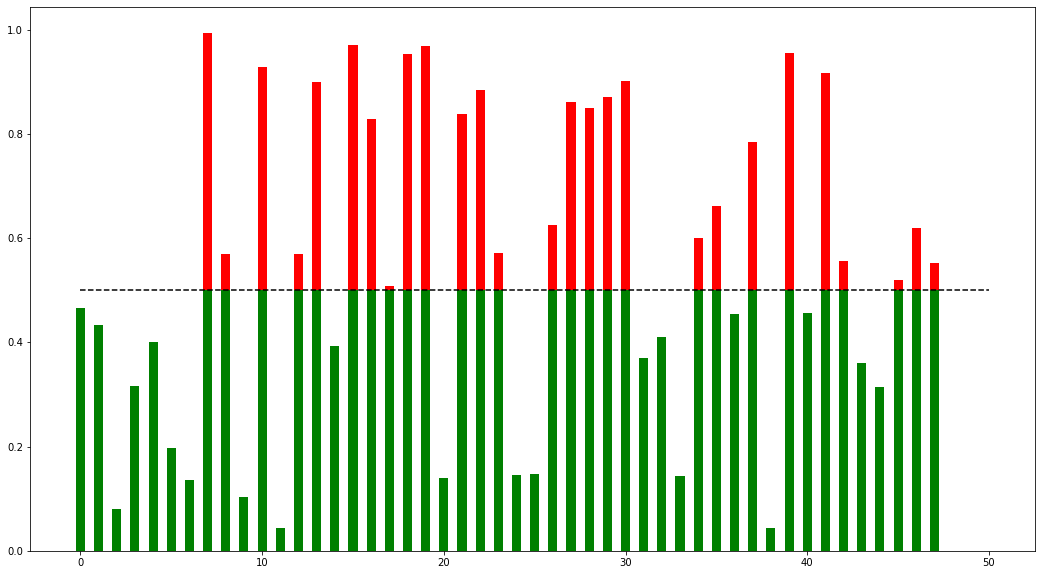

In [206]:
import numpy as np
import matplotlib.pyplot as plt

# some example data
threshold = 0.5
values = np.array(list(spam_percentages.values()))
x = range(len(values))

# split it up
above_threshold = np.maximum(values - threshold, 0)
below_threshold = np.minimum(values, threshold)

# and plot it
fig, ax = plt.subplots(figsize=(18,10))
ax.bar(x, below_threshold, 0.5, color="g")
ax.bar(x, above_threshold, 0.5, color="r",
        bottom=below_threshold)

# horizontal line indicating the threshold
ax.plot([0., 50], [threshold, threshold], "k--")

In [215]:
val_df_0

,lemmatized,spam
11814,"[miningnews, net, newsletter, tuesday, january...",True
20956,"[software, update, save, microsoft, window, pr...",True
5828,"[save, money, buy, get, thing, try, cialls, ye...",True
4906,"[real, option, conference, vince, bring, atten...",False
16712,"[credit, processing, easy, 189, aredit, cpprov...",True
...,...,...
15664,"[global, intelligence, status, attach, summary...",False
7327,"[draft, response, ferc, staff, attach, draft, ...",False
4010,"[mid, year, 2000, performance, feedback, note,...",False
10911,"[start, date, hourahead, hour, start, date, ho...",False


In [241]:
y_pred = [0] * len(val_df_0)

for i in range(len(val_df_0)):
    doc = val_df_0.iloc[i]
    lem = doc.lemmatized
    
    prob_dist = lda_model_0[dictionary_0.doc2bow(lem)]
    topic = max(prob_dist, key=lambda item:item[1])[0]
    
    if topic in spam_topics:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

In [250]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_eval(y_actual,y_pred):
    
    C = confusion_matrix(y_actual,y_pred)
    
    print("Confusion Matrix")
    print(C)
    
    print()
    
    print('Classification report')
    print(classification_report(y_actual, y_pred, target_names = ['Normal', 'Spam'], digits=3))

In [251]:
classification_eval(y_actual, y_pred)

Confusion Matrix
[[ 701   18]
 [  13 1262]]

Classification report
              precision    recall  f1-score   support

      Normal      0.982     0.975     0.978       719
        Spam      0.986     0.990     0.988      1275

    accuracy                          0.984      1994
   macro avg      0.984     0.982     0.983      1994
weighted avg      0.984     0.984     0.984      1994

